# Convolutional Networks
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.  
지금까지 우리는 Deep FC 네트워크를 다뤘다.  
Deep FC를 이용해 다양한 최적화 전략 및 네트워크 아키텍쳐를 살펴봤다.  
FC는 실험에 쓰기 참 좋은 테스트배드이다. 왜냐면 FC는 계산복잡도 면에서 매우 효율적이기 때문이다.  
하지만 현재 최고의 성과를 실제로 내고 있는 것은 convolutional 네트워크이다. 

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.  
처음 할 일은, 컨볼루셔널 네트워크에 사용되는 몇가지 타입의 레이어를 구현해 보는 것이다.  
그 다음 할 일은, 이 레이어들을 이용해 CIFAR-10 데이터세트에서 CNN을 훈련시킬 것이다. 

In [8]:
%%javascript
var fname = document.body.attributes['data-notebook-name'].value
var fpath = document.body.attributes['data-notebook-path'].value.replace(/^local/, '/root').replace(fname, '')
IPython.notebook.kernel.execute("theNoteBookDir = '" + fpath + "'" );

<IPython.core.display.Javascript object>

In [9]:
import os
os.chdir(theNoteBookDir)

In [11]:
# As usual, a bit of setup
# 이 셀을 맨 처음 실행하면
# assignment/cs231n 하위 폴더로 가서 
# python setup.py build_ext --inplace 라고 스크립트 실행시켜야 한다고 안내가 나옴.

import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.cnn import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


In [15]:
# inner 함수 변수 스코프 테스트. 
x = [0]

def test_01 ():
    x    = [1]
    x[0] = 11
test_01()
print 'test_01: ', x

def test_02 ():
    x[0] = 2
test_02()
print 'test_02: ', x

'''
def test_03():
    x[0] = 3
    x    = [33]
test_03()
print 'test_03: ', x
'''
def test_04 ():
    global x
    x[0] = 4
    x    = [44]
test_04()
print 'test_04: ', x

test_01:  [0]
test_02:  [2]
test_04:  [44]


In [16]:
# for index 변수 스코프 테스트
w = [0]
print w
for w in xrange(5):
    x = w
print x, w

[0]
4 4


In [64]:
# padding test
import itertools

def do_padding(x, pad): # 
    N,C,H,W = x.shape
    xpad = np.zeros((N, C, pad + H + pad, pad + W + pad))
    for n,c,h,w in itertools.product(xrange(N), xrange(C), xrange(H), xrange(W)):
        xpad[n][c][pad + h][pad + w] = x[n][c][h][w]
    return xpad

x = np.ones((2,2,2,2))
print 'x::\n', x
print 'xpad:\n', do_padding(x, 2)

# x -> np.pad :: (N, C, H, W) -> (N, C, pad + H + pad, pad + W + pad)
pad = 1
npad = ((0,0), (0,0), (pad, pad), (pad, pad)) # (before, after), ...
x = np.pad(x, pad_width=npad, mode='constant', constant_values=0)
print 'np.pad:\n', x

x::
[[[[ 1.  1.]
   [ 1.  1.]]

  [[ 1.  1.]
   [ 1.  1.]]]


 [[[ 1.  1.]
   [ 1.  1.]]

  [[ 1.  1.]
   [ 1.  1.]]]]
xpad:
[[[[ 0.  0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.  0.]
   [ 0.  0.  1.  1.  0.  0.]
   [ 0.  0.  1.  1.  0.  0.]
   [ 0.  0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.  0.]
   [ 0.  0.  1.  1.  0.  0.]
   [ 0.  0.  1.  1.  0.  0.]
   [ 0.  0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.  0.]]]


 [[[ 0.  0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.  0.]
   [ 0.  0.  1.  1.  0.  0.]
   [ 0.  0.  1.  1.  0.  0.]
   [ 0.  0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.  0.]
   [ 0.  0.  1.  1.  0.  0.]
   [ 0.  0.  1.  1.  0.  0.]
   [ 0.  0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.  0.]]]]
np.pad:
[[[[ 0.  0.  0.  0.]
   [ 0.  1.  1.  0.]
   [ 0.  1.  1.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.]
   [ 0.  1.  1.  0.]
   [ 0.  1.  1.  0.]
   [ 0.  0.

In [18]:
# unpad 테스트 
unpad = x[:,:,1:-1,1:-1]
print unpad

[[[[ 1.  1.]
   [ 1.  1.]]

  [[ 1.  1.]
   [ 1.  1.]]]


 [[[ 1.  1.]
   [ 1.  1.]]

  [[ 1.  1.]
   [ 1.  1.]]]]


# Convolution: Naive forward pass
The core of a convolutional network is the convolution operation.  
In the file `cs231n/layers.py`, implement the forward pass for the convolution layer in the function `conv_forward_naive`.   
`cs231n/layers.py` 파일의 `conv_forward_naive` 함수를 구현하시오.   
 `conv_forward_naive` 함수의 입출력 값은 다음 그림을 참고하시오.
![texte](https://cloud.githubusercontent.com/assets/1628848/20039453/8e39ae52-a487-11e6-9776-f1d306054535.png)  


You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.  
성능에 신경쓰지 말고 명확하게만 작성하시오.  

You can test your implementation by running the following:  
아래 셀을 실행시켜 구현내용을 테스트 하시오.



In [34]:
# 테스트 셀
# 가변인자 테스트
def var_f(*p): return tuple([3*x for x in list(p)])
print var_f(1,2,3)

(3, 6, 9)


In [35]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]]])

# Compare your output to ours; difference should be around 1e-8
print 'Testing conv_forward_naive'
print 'difference: ', rel_error(out, correct_out)

Testing conv_forward_naive
difference:  2.21214765759e-08


# Aside: Image processing via convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.  

우리가 작성한 conv_forward_naive 를 이용해서   
  흑백사진으로 변경도 해 보고  
  엣지 탐지도 해 보는  
재미있는(?) 예제 돌려보기.  

out.shape: (2, 3, 200, 200)


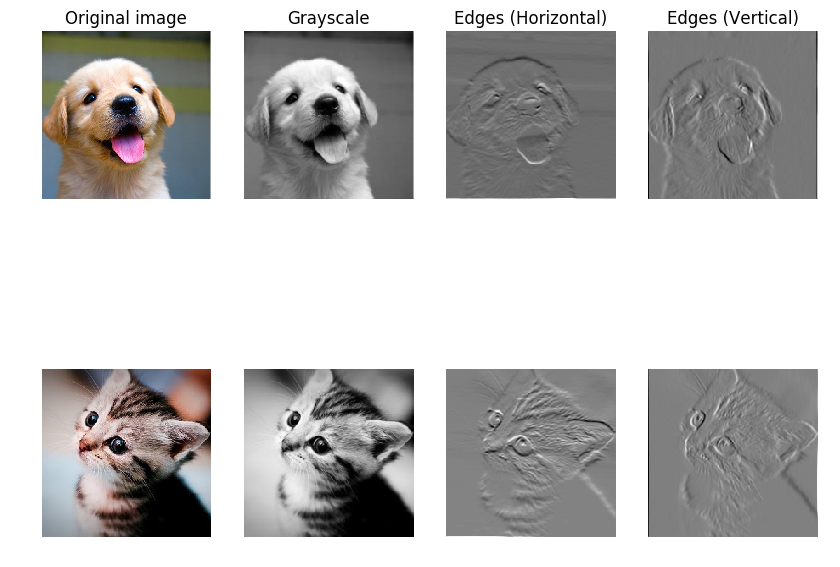

In [37]:
from scipy.misc import imread, imresize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d/2:-d/2, :]

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))

# Set up a convolutional weights holding 3 filters, each 3x3
w = np.zeros((3, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[ 1,  2,  1], 
                 [ 0,  0,  0], 
                 [-1, -2, -1]]  # <-- 수평 엣지 찾기.

w[2, 2, :, :] = [[ 1,  0, -1], 
                 [ 2,  0, -2], 
                 [ 1,  0, -1]]  # <-- 수직 엣지찾기.

'''
100 100 100     1  2  1  
12  123  12     0  0  0
1   0     2    -1 -2 -1

100 100 100     1  2  1  
12  123  12     0  0  0
99  101  90    -1 -2 -1

100 12   1     1  0 -1
100 123  0     2  0 -2
100 12   2     1  0 -1
'''

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})
print 'out.shape:', out.shape

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 4, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 4, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 4, 3)
imshow_noax(out[0, 1])
plt.title('Edges (Horizontal)')
plt.subplot(2, 4, 4)
imshow_noax(out[0, 2])
plt.title('Edges (Vertical)')
plt.subplot(2, 4, 5)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 4, 6)
imshow_noax(out[1, 0])
plt.subplot(2, 4, 7)
imshow_noax(out[1, 1])
plt.subplot(2, 4, 8)
imshow_noax(out[1, 2])

plt.show()

# Convolution: Naive backward pass
Implement the backward pass for the convolution operation in the function `conv_backward_naive` in the file `cs231n/layers.py`. Again, you don't need to worry too much about computational efficiency.   
- `cs231n/layers.py` 파일에 있는 `conv_backward_naive` 함수를 작성하여 백워드 패쓰를 구현하시오.   
- 백워드 함수 패턴은 다음과 같이 작성.  
![image](https://cloud.githubusercontent.com/assets/1628848/20087832/5403704a-a5bf-11e6-9295-93a85c49d841.png)

When you are done, run the following to check your backward pass with a numeric gradient check.  
작성 후 아래 셀을 돌려 검증하시오.  

In [38]:
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around 1e-9'
print 'Testing conv_backward_naive function'
print 'dx error: ', rel_error(dx, dx_num)
print 'dw error: ', rel_error(dw, dw_num)
print 'db error: ', rel_error(db, db_num)

Testing conv_backward_naive function
dx error:  6.86431036016e-09
dw error:  8.30858915219e-10
db error:  7.65561242652e-12


# Max pooling: Naive forward
Implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `cs231n/layers.py`. Again, don't worry too much about computational efficiency.  
- cs231n/layers.py 파일의 max_pool_forward_naive 함수를 구현하세요.  
- 계산 복잡도 성능을 너무 걱정하지 마세요.  
- conv_forward_naive 함수의 입출력 값은 다음 그림을 참고하세요.  
![texte](https://cloud.githubusercontent.com/assets/1628848/20079079/7a074228-a586-11e6-8144-d529efc1aa7b.png)

Check your implementation by running the following:  
- 아래 셀을 실행시켜 구현을 검증하세요.

In [39]:
# argmax 테스트
x = np.array([[1,2,3,4],
              [3,1,9,1],
              [1,1,1,1]])
idx = np.unravel_index(np.argmax(x), x.shape)
print 'idx:' , idx, ', x[idx]: ', x[idx]

idx: (1, 2) , x[idx]:  9


In [40]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be around 1e-8.
print 'Testing max_pool_forward_naive function:'
print 'difference: ', rel_error(out, correct_out)

Testing max_pool_forward_naive function:
difference:  4.16666651573e-08


# Max pooling: Naive backward
Implement the backward pass for the max-pooling operation in the function `max_pool_backward_naive` in the file `cs231n/layers.py`. You don't need to worry about computational efficiency.  
- cs231n/layers.py 파일의 max_pool_backward_naive 함수를 구현 하세요.  
- 계산 복잡도 성능을 너무 걱정하지 마세요.  

Check your implementation with numeric gradient checking by running the following:  
- 아래 셀을 실행시켜 numeric gradient 값과 비교해서 구현을 검증하세요.

In [41]:
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be around 1e-12
print 'Testing max_pool_backward_naive function:'
print 'dx error: ', rel_error(dx, dx_num)

Testing max_pool_backward_naive function:
dx error:  3.27562836492e-12


# Fast layers
Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers in the file `cs231n/fast_layers.py`.  
- 컨볼루션과 풀링 레이어를 빠르게 구현 하는 것은 참 어렵다.  
- 그래서 cs231n 강의 에서는  `cs231n/fast_layers.py` 파일에 빠른 구현을 해서 제공한다.

The fast convolution implementation depends on a Cython extension; to compile it you need to run the following from the `cs231n` directory:

```bash
python setup.py build_ext --inplace
```  
- 단, 아래와 같이 Cython을 설치해야 한다.
- assignment2/cs231n> python setup.py build_ext

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**NOTE:** The fast implementation for pooling will only perform optimally if the pooling regions are non-overlapping and tile the input. If these conditions are not met then the fast pooling implementation will not be much faster than the naive implementation.

You can compare the performance of the naive and fast versions of these layers by running the following:  
- 아래 셀을 실행시켜 두 버전의 속도를 비교해 보라.

In [131]:
from cs231n.fast_layers import conv_forward_fast, conv_backward_fast
from time import time

x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)

dout       = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print 'Testing conv_forward_fast:'
print 'Naive: %fs' % (t1 - t0)
print 'Fast: %fs' % (t2 - t1)
print 'Speedup: %fx' % ((t1 - t0) / (t2 - t1))
print 'Difference: ', rel_error(out_naive, out_fast)

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print '\nTesting conv_backward_fast:'
print 'Naive: %fs' % (t1 - t0)
print 'Fast: %fs' % (t2 - t1)
print 'Speedup: %fx' % ((t1 - t0) / (t2 - t1))
print 'dx difference: ', rel_error(dx_naive, dx_fast)
print 'dw difference: ', rel_error(dw_naive, dw_fast)
print 'db difference: ', rel_error(db_naive, db_fast)

Testing conv_forward_fast:
Naive: 15.626653s
Fast: 0.005781s
Speedup: 2703.135769x
Difference:  1.08695492591e-11

Testing conv_backward_fast:
Naive: 29.991239s
Fast: 0.006364s
Speedup: 4712.736925x
dx difference:  9.82717359978e-12
dw difference:  1.13505279309e-14
db difference:  0.0


In [43]:
from cs231n.fast_layers import max_pool_forward_fast, max_pool_backward_fast

x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print 'Testing pool_forward_fast:'
print 'Naive: %fs' % (t1 - t0)
print 'fast: %fs' % (t2 - t1)
print 'speedup: %fx' % ((t1 - t0) / (t2 - t1))
print 'difference: ', rel_error(out_naive, out_fast)

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print '\nTesting pool_backward_fast:'
print 'Naive: %fs' % (t1 - t0)
print 'speedup: %fx' % ((t1 - t0) / (t2 - t1))
print 'dx difference: ', rel_error(dx_naive, dx_fast)

Testing pool_forward_fast:
Naive: 0.549664s
fast: 0.001972s
speedup: 278.706238x
difference:  0.0

Testing pool_backward_fast:
Naive: 0.378626s
speedup: 31.042515x
dx difference:  0.0


# Convolutional "sandwich" layers
Previously we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. In the file `cs231n/layer_utils.py` you will find sandwich layers that implement a few commonly used patterns for convolutional networks.  
- 이전에 `cs231n/layer_utils.py` 에 구현된  "센드위치" 레이어를 소개했었는데 
- CNN 구현 시 일반적으로 나오는 패턴 구현에 사용할 수 있다.  


In [48]:
from cs231n.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward

x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

print 'Testing conv_relu_pool'
print 'dx error: ', rel_error(dx_num, dx)
print 'dw error: ', rel_error(dw_num, dw)
print 'db error: ', rel_error(db_num, db)

Testing conv_relu_pool
dx error:  1.23474661396e-08
dw error:  9.21211424276e-08
db error:  5.58079375132e-10


In [49]:
from cs231n.layer_utils import conv_relu_forward, conv_relu_backward

x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

print 'Testing conv_relu:'
print 'dx error: ', rel_error(dx_num, dx)
print 'dw error: ', rel_error(dw_num, dw)
print 'db error: ', rel_error(db_num, db)

Testing conv_relu:
dx error:  7.3651124765e-09
dw error:  5.3562891014e-08
db error:  1.69024168664e-11


# Three-layer ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `cs231n/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Run the following cells to help you debug:  
- `cs231n/classifiers/cnn.py` 파일을 열고 `ThreeLayerConvNet` 클래스 구현을 완성하시오.  


## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [135]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print 'Initial loss (no regularization): ', loss

model.reg = 0.5
loss, grads = model.loss(X, y)
print 'Initial loss (with regularization): ', loss

print 'log(10):', np.log(10)


y.shape (50,) , scores.shape (50, 10)
loss 2.30258621452 dout.shape (50, 10)
Initial loss (no regularization):  2.30258621452
y.shape (50,) , scores.shape (50, 10)
loss 2.30258621452 dout.shape (50, 10)
Initial loss (with regularization):  2.50890834806
log(10): 2.30258509299


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

In [51]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))
    

W1 max relative error: 3.244589e-04
W2 max relative error: 1.178159e-03
W3 max relative error: 6.504115e-05
b1 max relative error: 1.920454e-04
b2 max relative error: 9.508115e-08
b3 max relative error: 1.923765e-09


## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [52]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 20) loss: 2.467996
(Epoch 0 / 10) train acc: 0.180000; val_acc: 0.116000
(Iteration 2 / 20) loss: 3.564509
(Epoch 1 / 10) train acc: 0.210000; val_acc: 0.121000
(Iteration 3 / 20) loss: 2.688228
(Iteration 4 / 20) loss: 2.230013
(Epoch 2 / 10) train acc: 0.270000; val_acc: 0.104000
(Iteration 5 / 20) loss: 2.302355
(Iteration 6 / 20) loss: 2.187804
(Epoch 3 / 10) train acc: 0.400000; val_acc: 0.126000
(Iteration 7 / 20) loss: 1.885076
(Iteration 8 / 20) loss: 1.844856
(Epoch 4 / 10) train acc: 0.410000; val_acc: 0.150000
(Iteration 9 / 20) loss: 1.743222
(Iteration 10 / 20) loss: 1.445493
(Epoch 5 / 10) train acc: 0.400000; val_acc: 0.161000
(Iteration 11 / 20) loss: 1.500743
(Iteration 12 / 20) loss: 1.142353
(Epoch 6 / 10) train acc: 0.610000; val_acc: 0.192000
(Iteration 13 / 20) loss: 1.297972
(Iteration 14 / 20) loss: 1.098153
(Epoch 7 / 10) train acc: 0.670000; val_acc: 0.207000
(Iteration 15 / 20) loss: 0.970756
(Iteration 16 / 20) loss: 0.705445
(Epoch 8 / 10) tr

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

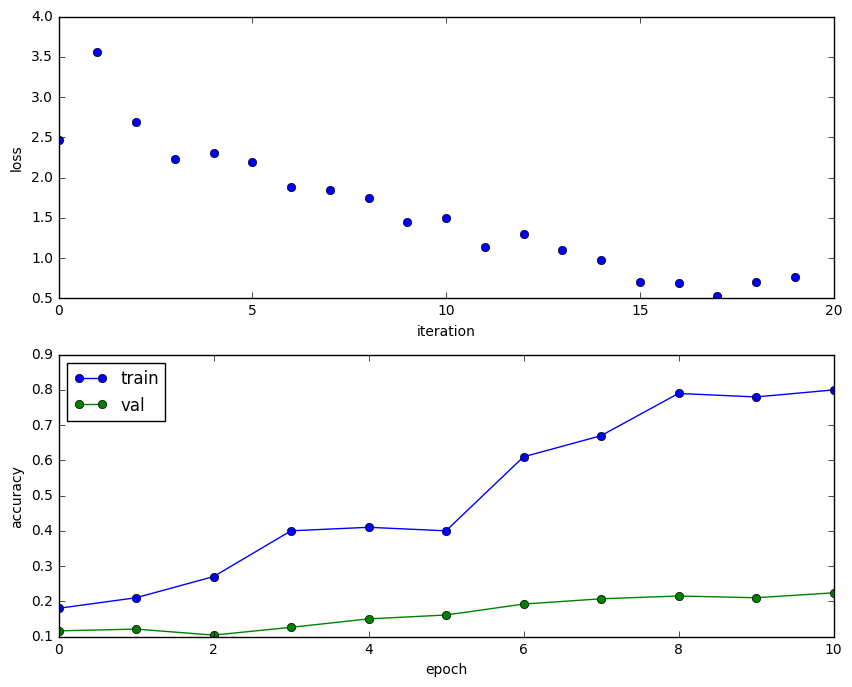

In [53]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [55]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 980) loss: 2.304546
(Epoch 0 / 1) train acc: 0.105000; val_acc: 0.105000
(Iteration 21 / 980) loss: 2.247494
(Iteration 41 / 980) loss: 2.106396
(Iteration 61 / 980) loss: 2.021978
(Iteration 81 / 980) loss: 1.827684
(Iteration 101 / 980) loss: 1.989989
(Iteration 121 / 980) loss: 1.962374
(Iteration 141 / 980) loss: 1.931592
(Iteration 161 / 980) loss: 1.766724
(Iteration 181 / 980) loss: 1.688407
(Iteration 201 / 980) loss: 1.977639
(Iteration 221 / 980) loss: 1.753734
(Iteration 241 / 980) loss: 1.662786
(Iteration 261 / 980) loss: 1.959009
(Iteration 281 / 980) loss: 1.623759
(Iteration 301 / 980) loss: 1.899353
(Iteration 321 / 980) loss: 1.652108
(Iteration 341 / 980) loss: 1.956983
(Iteration 361 / 980) loss: 1.510676
(Iteration 381 / 980) loss: 1.708700
(Iteration 401 / 980) loss: 1.667899
(Iteration 421 / 980) loss: 1.588144
(Iteration 441 / 980) loss: 1.967463
(Iteration 461 / 980) loss: 1.539578
(Iteration 481 / 980) loss: 1.591978
(Iteration 501 / 980) loss: 

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

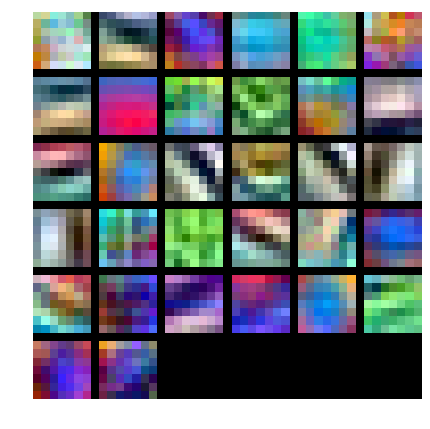

In [56]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Spatial Batch Normalization
We already saw that batch normalization is a very useful technique for training deep fully-connected networks. Batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect the statistics of each feature channel to be relatively consistent both between different images and different locations within the same image. Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over both the minibatch dimension `N` and the spatial dimensions `H` and `W`.

## Spatial batch normalization: forward

In the file `cs231n/layers.py`, implement the forward pass for spatial batch normalization in the function `spatial_batchnorm_forward`. Check your implementation by running the following:

In [58]:
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print 'Before spatial batch normalization:'
print '  Shape: ', x.shape
print '  Means: ', x.mean(axis=(0, 2, 3))
print '  Stds: ',  x.std(axis=(0, 2, 3))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print 'After spatial batch normalization:'
print '  Shape: ', out.shape
print '  Means: ', out.mean(axis=(0, 2, 3))
print '  Stds: ', out.std(axis=(0, 2, 3))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print 'After spatial batch normalization (nontrivial gamma, beta):'
print '  Shape: ', out.shape
print '  Means: ', out.mean(axis=(0, 2, 3))
print '  Stds: ', out.std(axis=(0, 2, 3))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 10.05655722  10.09003196  10.40919487]
  Stds:  [ 3.44966625  3.96838544  3.60219497]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [  1.44328993e-16  -2.22044605e-16  -1.97064587e-16]
  Stds:  [ 0.99999958  0.99999968  0.99999961]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.  7.  8.]
  Stds:  [ 2.99999874  3.99999873  4.99999807]


In [59]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in xrange(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print 'After spatial batch normalization (test-time):'
print '  means: ', a_norm.mean(axis=(0, 2, 3))
print '  stds: ', a_norm.std(axis=(0, 2, 3))

After spatial batch normalization (test-time):
  means:  [ 0.0633348   0.02750597  0.00287851  0.00921591]
  stds:  [ 0.99744643  1.013969    1.02321444  1.01738796]


## Spatial batch normalization: backward
In the file `cs231n/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_batchnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [60]:
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print 'dx error: ', rel_error(dx_num, dx)
print 'dgamma error: ', rel_error(da_num, dgamma)
print 'dbeta error: ', rel_error(db_num, dbeta)

dx error:  6.69291526727e-08
dgamma error:  4.75252238821e-12
dbeta error:  1.1887708813e-11


# Experiment! 실험!
Experiment and try to get the best performance that you can on CIFAR-10 using a ConvNet. Here are some ideas to get you started:  
ConvNet을 CIFAR-10 데이터에 대해 적용하여 최대의 성능을 이끌어내는 실험을 하라.  
시작할 때 필요한 몇 가지 아이디어가 있다.

### Things you should try: 시도해 봐야 하는 것들:  
- Filter size: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- 필터 크기: 위에서는 이쁜(?) 그림을 만드는  7x7 을 사용했다. 하지만 작은 크기 필터가 더 효율적일 수 있다.  
- Number of filters: Above we used 32 filters. Do more or fewer do better?
- 필터 갯수: 위에서는 32개 사용했다. 더 적거나 더 많이 하는 것이 더 나을까?  
- Batch normalization: Try adding spatial batch normalization after convolution layers and vanilla batch normalization aafter affine layers. Do your networks train faster?
- 배치 노말라이제이션 : 컨볼루션 레이어 다음에  spatial 배치 노말라이제이션을 해 보라. affine 레이어 다음에는 (일반적인) 배치 노말라이제이션을 써 보라. 훈련이 좀 더 빠르게 진행되는 지 살펴 봐라.
- Network architecture: The network above has two layers of trainable parameters. Can you do better with a deeper network? You can implement alternative architectures in the file `cs231n/classifiers/convnet.py`. Some good architectures to try include:
- 네트워크 구조: 위에서는 훈련 가능한 패러미터를 갖는 레이어가 두 개 였다.  
  더 깊게 해서 더 좋아지게 할 수 있을까?
  `cs231n/classifiers/convnet.py` 파일에 여러 다른 구조를 구현해 볼 수 있다.  
  좋은 구조의 몇 가지 예는 다음과 같다.  
    - [conv-relu-pool]xN - conv - relu - [affine]xM - [softmax or SVM]
    - [conv-relu-pool]xN - [affine]xM - [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN - [affine]xM - [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN - - [conv-relu-conv-relu-pool]xM -  [affine]xL - [softma] <== VGG like
     ![image](https://cloud.githubusercontent.com/assets/1628848/20246187/ef9c6aa0-a9f4-11e6-9499-26b90c5fecb8.png)

### Tips for training. 훈련을 위한 팁
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the course-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, or MaxOut.
- Model ensembles
- Data augmentation

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at least 65% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training, validation, and test set accuracies for your final trained network. In this notebook you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

Have fun and happy training!

In [151]:
def add(x, y) : return x+ y

def f1(x):
    dX = x +5
    def f2():
        return  lambda x: add(dX, x)
    return f2()

f = f1(5)
print f(8)



18


### from cs231n.classifiers.convnet import *
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = Simple_VGG_16(scale_factor = 8)

solver = Solver(model, small_data,
                num_epochs=50, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-4,
                },
                verbose=True, print_every=100)
solver.train()

In [ ]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = Simple_VGG_16(scale_factor = 8)

solver = Solver(model, small_data,
                num_epochs=1000, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 10 ** (-4),
                },
                verbose=True, print_every=50)
solver.train()

debug 0
(Iteration 1 / 2000) loss: 2.302585
(Epoch 0 / 1000) train acc: 0.130000; val_acc: 0.112000
(Epoch 1 / 1000) train acc: 0.130000; val_acc: 0.079000
(Epoch 2 / 1000) train acc: 0.130000; val_acc: 0.079000


In [170]:
from cs231n.classifiers.convnet import *

vgg16_S1  = Simple_VGG_16(scale_factor = 16)
#vgg16_S1  = ThreeLayerConvNet()
solver_S1 = Solver(vgg16_S1, data,
                  num_epochs=1, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 10**-2.9,
                  },
                  verbose=True, print_every=50)

debug 0


(Iteration 1 / 980) loss: 2.302697
(Epoch 0 / 1) train acc: 0.078000; val_acc: 0.071000
(Iteration 6 / 980) loss: 2.198965
(Iteration 11 / 980) loss: 2.305880
(Iteration 16 / 980) loss: 2.171639
(Iteration 21 / 980) loss: 2.113142
(Iteration 26 / 980) loss: 2.085952
(Iteration 31 / 980) loss: 2.214478
(Iteration 36 / 980) loss: 1.983934
(Iteration 41 / 980) loss: 1.929195
(Iteration 46 / 980) loss: 2.111577
(Iteration 51 / 980) loss: 1.906872
(Iteration 56 / 980) loss: 2.093425
(Iteration 61 / 980) loss: 2.229782
(Iteration 66 / 980) loss: 2.100809
(Iteration 71 / 980) loss: 1.997700
(Iteration 76 / 980) loss: 2.329811
(Iteration 81 / 980) loss: 2.048423
(Iteration 86 / 980) loss: 2.045055
(Iteration 91 / 980) loss: 1.891143
(Iteration 96 / 980) loss: 2.056602
(Iteration 101 / 980) loss: 1.976028
(Iteration 106 / 980) loss: 1.983715
(Iteration 111 / 980) loss: 1.995329
(Iteration 116 / 980) loss: 1.987095
(Iteration 121 / 980) loss: 1.956213
(Iteration 126 / 980) loss: 2.344719
(Iterat

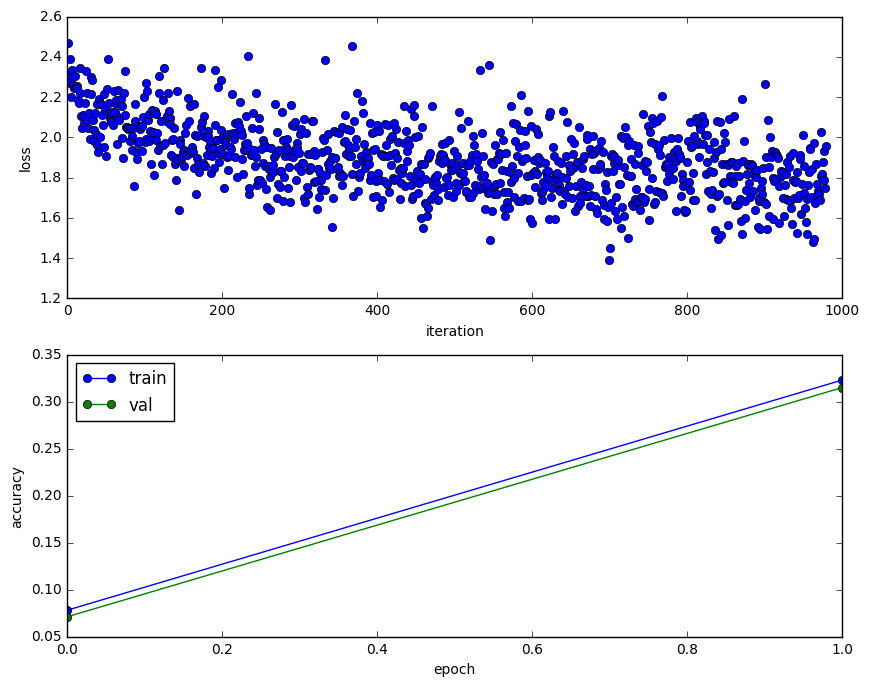

In [129]:
solver_S1.num_epochs=1
solver_S1.print_every=5
solver_S1.train()

plt.subplot(2, 1, 1)
plt.plot(solver_S1.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver_S1.train_acc_history, '-o')
plt.plot(solver_S1.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [96]:
def f_add_4(x, y, z, w):
    return x+y+z+w

tt  = lambda *xs : f_add_4(1, 2, *xs)
ttt = lambda *xs : f_add_4(1, 2, 3, *xs)
tttt = lambda *xs : f_add_4(1, 2, 3, 4, *xs)
print tt(3,4)
print ttt(4)
print tttt()

print 'W'+ `3`
for i in reversed(xrange(1, 17)):
    print i

10
10
10
W3
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [ ]:
# Train a really good model on CIFAR-10

# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.